In [339]:
'''
!pip install pyyaml
!pip install matplotlib-venn
!pip install numpy
!pip install maya
'''
!pip install decorator==5.0.5

  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.7
    Uninstalling decorator-5.0.7:
      Successfully uninstalled decorator-5.0.7


In [337]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style("whitegrid")
from pprint import pprint
import sqlite3
import yaml
import re
from datetime import datetime
import maya
from collections import Counter
from glob import glob
import ast
import json
from sklearn.preprocessing import StandardScaler

try: # for pip >= 10
    from pip._internal.req import parse_requirements
except ImportError: # for pip <= 9.0.3
    from pip.req import parse_requirements

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

import networkx as nx
import networkx.algorithms.community as nxcom

import bokeh.io
from bokeh.io import output_file, show
from bokeh.resources import INLINE
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool,
                         BoxZoomTool, ResetTool, OpenURL, CustomJS, Column, SaveTool)
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook
from bokeh.models.graphs import from_networkx
from bokeh.models import TextInput, Button

%matplotlib inline

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

## Easier navigation:

------------------------------------

### 1. <a href='#setup1'>Setup timing csv</a>
### 2. <a href='#setup2'>Setup dependency/size csv</a>
### 3. <a href='#setup3'>Setup scrape csv</a>
------------------------------------
### 4. <a href='#e1'>Timing csv EDA</a>
### 5. <a href='#e2'>Dependency/size csv EDA</a>
### 6. <a href='#e3'>Scrape csv EDA</a>
------------------------------------
### 7. <a href='#merge'>Merge CSVs</a>
------------------------------------
### 8. <a href='#c1'>Correlational plots for time vs size</a>

<a name='setup1'></a>
## 1. Setup timing csv


 - Time to install package
<br>

In [174]:
t_df = pd.read_csv("combined_times.csv").drop([0,1])
t_df.columns = ["library", "real avg", "real std", "real max", "count", "sys avg", "sys std", "sys max", "user avg", "user std", "user max"]
t_df["library"] = t_df["library"].str.lower()
t_df = t_df.reset_index().drop("index", axis=1)
t_df.iloc[:, 1:] = t_df.iloc[:, 1:].astype(float)
t_df

,library,real avg,real std,real max,count,sys avg,sys std,sys max,user avg,user std,user max
0,babel,1.987,NaN,1.987,1.0,0.225,NaN,0.225,1.712,NaN,1.712
1,beautifulsoup4,1.252,NaN,1.252,1.0,0.138,NaN,0.138,1.057,NaN,1.057
2,biopython,2.564,NaN,2.564,1.0,0.372,NaN,0.372,1.999,NaN,1.999
3,bondgraphtools,1.044,NaN,1.044,1.0,0.155,NaN,0.155,0.853,NaN,0.853
4,bottleneck,7.08,NaN,7.08,1.0,4.799,NaN,4.799,8.536,NaN,8.536
...,...,...,...,...,...,...,...,...,...,...,...
3187,zope.event,0.87,NaN,0.87,1.0,0.093,NaN,0.093,0.738,NaN,0.738
3188,zope.index,3.336,NaN,3.336,1.0,0.266,NaN,0.266,2.82,NaN,2.82
3189,zope.interface,1.5125,0.019092,1.526,2.0,0.155,0.041012,0.184,1.316,0.024042,1.333
3190,zstandard,1.3235,0.064347,1.369,2.0,0.136,0.001414,0.137,1.0705,0.060104,1.113


<a name='setup2'></a>
## 2. Setup dependency/size csv

 - Package size
 - Package dependencies
<br>

3 methods for string representation of list to list:
- Eval()
- ast_literal eval()
- strip 

In [313]:
ds_df = pd.DataFrame()

files = glob("pip_dep*")

for file in files:
    temp_df = pd.read_csv(file, index_col=0)
    ds_df = ds_df.append(temp_df)

for i in np.arange(len(ds_df["dependencies"])):
    try:
        ds_df["dependencies"][i] = eval(ds_df["dependencies"][i])
    except:
        pass

    
ds_df

,library,dependencies,size,size_full
0,matplotlib,"[python-dateutil, kiwisolver, numpy, six, cycl...",98.800,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...
1,numpy,[],70.000,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...
2,pandas,"[numpy, python-dateutil, pytz]",120.800,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...
3,scipy,[numpy],158.000,88M /home/ubuntu/ve/randomenv/lib/python2.7/si...
4,ipywidgets,"[traitlets, ipython, nbformat, widgetsnbextens...",66.284,39M /home/ubuntu/ve/randomenv/lib/python2.7/si...
...,...,...,...,...
2995,natasha,"[navec, slovnet, yargy, ipymarkup, pymorphy2, ...",108.584,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...
2996,pdfminer-six,"[pycryptodome, sortedcontainers, six]",0.256,11M /home/ubuntu/ve/randomenv/lib/python2.7/si...
2997,sumy,[],2.824,11M /home/ubuntu/ve/randomenv/lib/python2.7/si...
2998,jupyterlab-dash,[],0.000,11M /home/ubuntu/ve/randomenv/lib/python2.7/si...


<a name='setup3'></a>
## 3. Setup scrape csv

 - Package stats
 - Package versions
<br>

In [360]:
pd.read_csv("scraper_0_1952.csv")["Version Number"][0]

"['3.4.2', '3.4.1', '3.4.0', '3.4.0rc3', '3.4.0rc2', '3.4.0rc1', '3.3.4', '3.3.3', '3.3.2', '3.3.1', '3.3.0', '3.3.0rc1', '3.2.2', '3.2.1', '3.2.0', '3.2.0rc3', '3.1.3', '3.1.2', '3.2.0rc1', '3.1.1', '3.1.0', '3.1.0rc2', '3.1.0rc1', '3.0.3', '3.0.2', '3.0.1', '3.0.0', '2.2.5', '2.2.4', '3.0.0rc2']"

In [278]:
s_df = pd.read_csv("scraper_0_1952.csv")
s_df = s_df.drop("Unnamed: 0", axis=1)

for i in np.arange(len(s_df["Version Number"])):
    try:
        s_df["Version Number"][i] = s_df["Version Number"][i].strip('][').split(', ')
        s_df["Version Time"][i] = json.loads(s_df["Version Time"][i])
    except:
        pass

s_df

,library,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,Forks,Latest release,Open Issues/PRs,Repository size,SourceRank,Stars,Total releases,Version Number,Version Time,Watchers
0,matplotlib,763.0,0.0,10100.0,39600.0,"Jan 9, 2006",5858.0,about a month ago,1656.0,377.00,28.0,13779.0,68.0,"['3.4.2', '3.4.1', '3.4.0', '3.4.0rc3', '3.4.0...","[datetime.datetime(2021, 5, 8, 5, 47, tzinfo=<...",569.0
1,numpy,736.0,0.0,25100.0,84900.0,"Dec 2, 2006",5611.0,10 days ago,2311.0,89.10,29.0,17409.0,100.0,"['1.21.0rc2', '1.21.0rc1', '1.20.3', '1.20.2',...","[datetime.datetime(2021, 6, 8, 16, 38, tzinfo=...",558.0
2,pandas,970.0,6.0,14400.0,38400.0,"Dec 25, 2009",12543.0,4 days ago,3657.0,219.00,28.0,30072.0,92.0,"['1.3.0rc1', '1.2.4', '1.2.3', '1.2.2', '1.2.1...","[datetime.datetime(2021, 6, 13, 19, 56, tzinfo...",1113.0
3,scipy,680.0,1.0,10400.0,43400.0,"Jul 27, 2010",3751.0,4 days ago,1657.0,128.00,26.0,8303.0,65.0,"['1.7.0rc2', '1.7.0rc1', '1.6.3', '1.6.2', '1....","[datetime.datetime(2021, 6, 14, 15, 26, tzinfo...",329.0
4,ipywidgets,NaN,8.0,734.0,7470.0,"Aug 3, 2015",NaN,"Feb 22, 2021",NaN,NaN,17.0,NaN,123.0,"['8.0.0a4', '8.0.0a3', '8.0.0a2', '8.0.0a1', '...","[datetime.datetime(2021, 2, 22, 20, 59, tzinfo...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1948,region,7.0,8.0,1.0,1.0,"May 8, 2018",16.0,"Jan 26, 2020",NaN,1.71,9.0,10.0,3.0,"['0.2.1', '0.2.0', '0.1.5']","[datetime.datetime(2020, 1, 26, 22, 31, tzinfo...",18.0
1949,cma,6.0,2.0,36.0,42.0,"May 12, 2014",102.0,"Apr 23, 2020",NaN,1.33,17.0,569.0,17.0,"['3.0.3', '3.0.2', '3.0.1', '3.0.0', '2.7.0', ...","[datetime.datetime(2020, 4, 23, 22, 52, tzinfo...",17.0
1950,causalgraphicalmodels,1.0,4.0,0.0,1.0,"Jul 1, 2018",0.0,"Sep 3, 2018",NaN,43.90,8.0,10.0,2.0,"['0.0.4', '0.0.3']","[datetime.datetime(2018, 9, 3, 17, 20, tzinfo=...",1.0
1951,napari,NaN,52.0,52.0,1.0,"Jul 30, 2018",NaN,about 24 hours ago,NaN,NaN,9.0,NaN,109.0,"['0.4.10', '0.4.10rc0', '0.4.9', '0.4.9rc3', '...","[datetime.datetime(2021, 6, 17, 18, 20, tzinfo...",NaN


In [361]:
s_df["Version Time"][0]

'[datetime.datetime(2021, 5, 8, 5, 47, tzinfo=<UTC>), datetime.datetime(2021, 3, 31, 8, 18, tzinfo=<UTC>), datetime.datetime(2021, 3, 26, 7, 50, tzinfo=<UTC>), datetime.datetime(2021, 3, 11, 5, 40, tzinfo=<UTC>), datetime.datetime(2021, 3, 11, 2, 56, tzinfo=<UTC>), datetime.datetime(2021, 2, 19, 6, 41, tzinfo=<UTC>), datetime.datetime(2021, 1, 28, 8, 34, tzinfo=<UTC>), datetime.datetime(2020, 11, 12, 4, 43, tzinfo=<UTC>), datetime.datetime(2020, 9, 15, 7, 11, tzinfo=<UTC>), datetime.datetime(2020, 8, 24, 22, 26, tzinfo=<UTC>), datetime.datetime(2020, 7, 17, 20, 21, tzinfo=<UTC>), datetime.datetime(2020, 6, 18, 22, 11, tzinfo=<UTC>), datetime.datetime(2020, 6, 17, 19, 42, tzinfo=<UTC>), datetime.datetime(2020, 3, 18, 22, 6, tzinfo=<UTC>), datetime.datetime(2020, 3, 4, 23, 27, tzinfo=<UTC>), datetime.datetime(2020, 2, 3, 6, 5, tzinfo=<UTC>), datetime.datetime(2020, 2, 3, 6, 2, tzinfo=<UTC>), datetime.datetime(2019, 11, 21, 22, 51, tzinfo=<UTC>), datetime.datetime(2019, 10, 25, 3, 56, tzi

<a name='merge'></a>
## 4. Merge CSVs

<br>

In [315]:
merge_df = ds_df.merge(s_df, on="library").merge(t_df, on="library")
merge_df

,library,dependencies,size,size_full,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,Forks,...,real avg,real std,real max,count,sys avg,sys std,sys max,user avg,user std,user max
0,matplotlib,"[python-dateutil, kiwisolver, numpy, six, cycl...",98.800,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...,763.0,0.0,10100.0,39600.0,"Jan 9, 2006",5858.0,...,5.8863,0.218406,6.394,10.0,0.5602,0.044919,0.661,5.1363,0.142811,5.447
1,numpy,[],70.000,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...,736.0,0.0,25100.0,84900.0,"Dec 2, 2006",5611.0,...,3.029,NaN,3.029,1.0,0.316,NaN,0.316,2.652,NaN,2.652
2,numpy,[],70.000,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...,736.0,0.0,25100.0,84900.0,"Dec 2, 2006",5611.0,...,3.1207,0.039472,3.194,10.0,0.3194,0.043095,0.387,2.7519,0.053297,2.827
3,pandas,"[numpy, python-dateutil, pytz]",120.800,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...,970.0,6.0,14400.0,38400.0,"Dec 25, 2009",12543.0,...,6.885,NaN,6.885,1.0,0.611,NaN,0.611,6.181,NaN,6.181
4,pandas,"[numpy, python-dateutil, pytz]",120.800,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...,970.0,6.0,14400.0,38400.0,"Dec 25, 2009",12543.0,...,6.543222,0.181254,6.87,9.0,0.629556,0.063287,0.736,5.820889,0.140243,6.043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,region,[],0.000,11M /home/ubuntu/ve/randomenv/lib/python2.7/si...,7.0,8.0,1.0,1.0,"May 8, 2018",16.0,...,1.146,NaN,1.146,1.0,0.167,NaN,0.167,0.899,NaN,0.899
2009,cma,[numpy],71.600,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...,6.0,2.0,36.0,42.0,"May 12, 2014",102.0,...,3.356,NaN,3.356,1.0,0.358,NaN,0.358,2.905,NaN,2.905
2010,causalgraphicalmodels,[],0.000,11M /home/ubuntu/ve/randomenv/lib/python2.7/si...,1.0,4.0,0.0,1.0,"Jul 1, 2018",0.0,...,1.086,NaN,1.086,1.0,0.172,NaN,0.172,0.83,NaN,0.83
2011,napari,[],0.000,11M /home/ubuntu/ve/randomenv/lib/python2.7/si...,NaN,52.0,52.0,1.0,"Jul 30, 2018",NaN,...,0.832,NaN,0.832,1.0,0.105,NaN,0.105,0.694,NaN,0.694


In [316]:
len(merge_df[merge_df["size"] == 0])

868

In [317]:
df = merge_df.drop(merge_df[merge_df["size"] == 0].index)

In [318]:
df

,library,dependencies,size,size_full,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,Forks,...,real avg,real std,real max,count,sys avg,sys std,sys max,user avg,user std,user max
0,matplotlib,"[python-dateutil, kiwisolver, numpy, six, cycl...",98.800,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...,763.0,0.0,10100.0,39600.0,"Jan 9, 2006",5858.0,...,5.8863,0.218406,6.394,10.0,0.5602,0.044919,0.661,5.1363,0.142811,5.447
1,numpy,[],70.000,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...,736.0,0.0,25100.0,84900.0,"Dec 2, 2006",5611.0,...,3.029,NaN,3.029,1.0,0.316,NaN,0.316,2.652,NaN,2.652
2,numpy,[],70.000,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...,736.0,0.0,25100.0,84900.0,"Dec 2, 2006",5611.0,...,3.1207,0.039472,3.194,10.0,0.3194,0.043095,0.387,2.7519,0.053297,2.827
3,pandas,"[numpy, python-dateutil, pytz]",120.800,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...,970.0,6.0,14400.0,38400.0,"Dec 25, 2009",12543.0,...,6.885,NaN,6.885,1.0,0.611,NaN,0.611,6.181,NaN,6.181
4,pandas,"[numpy, python-dateutil, pytz]",120.800,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...,970.0,6.0,14400.0,38400.0,"Dec 25, 2009",12543.0,...,6.543222,0.181254,6.87,9.0,0.629556,0.063287,0.736,5.820889,0.140243,6.043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,requests_toolbelt,[requests],4.096,11M /home/ubuntu/ve/randomenv/lib/python2.7/si...,NaN,1.0,659.0,4090.0,"Jan 18, 2014",NaN,...,1.947,NaN,1.947,1.0,0.161,NaN,0.161,1.678,NaN,1.678
2004,neovim,[pynvim],2.088,11M /home/ubuntu/ve/randomenv/lib/python2.7/si...,45.0,1.0,8.0,255.0,"May 9, 2014",96.0,...,3.857,NaN,3.857,1.0,0.623,NaN,0.623,3.148,NaN,3.148
2005,praat-parselmouth,[numpy],70.000,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...,3.0,1.0,4.0,7.0,"Jun 11, 2017",59.0,...,4.154,NaN,4.154,1.0,0.45,NaN,0.45,3.288,NaN,3.288
2009,cma,[numpy],71.600,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...,6.0,2.0,36.0,42.0,"May 12, 2014",102.0,...,3.356,NaN,3.356,1.0,0.358,NaN,0.358,2.905,NaN,2.905


<a name='e1'></a>
## 5. Timing csv EDA


 - Time to install package
 
 Columns: ['library', 'real avg', 'real std', 'real max', 'count', 'sys avg','sys std', 'sys max', 'user avg', 'user std', 'user max']
<br>

Let's say for now, we take the real time.

<AxesSubplot:xlabel='real avg', ylabel='Density'>

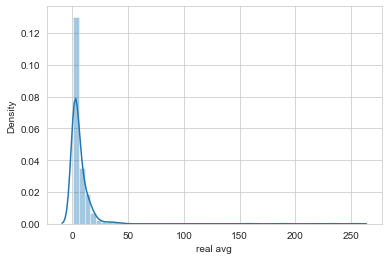

In [179]:
sns.distplot(df["real avg"])

Difference between max and avg for count > 1

In [180]:
bigcount = df[df["count"].apply(lambda x: float(x)) > 1]

<AxesSubplot:>

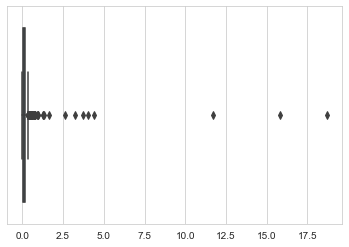

In [181]:
sns.boxplot(bigcount["real max"].astype(float) - bigcount["real avg"].astype(float))

<a name='e2'></a>
## 6. Dependency/size csv EDA

 - Package size
 - Package dependencies
 
 Columns: ['library', 'dependencies', 'size', 'size_full']
<br>

Why is package name not in install?

In [140]:
df["size_full"]

0       70M /home/ubuntu/ve/randomenv/lib/python2.7/si...
1       70M /home/ubuntu/ve/randomenv/lib/python2.7/si...
2       70M /home/ubuntu/ve/randomenv/lib/python2.7/si...
3       70M /home/ubuntu/ve/randomenv/lib/python2.7/si...
4       70M /home/ubuntu/ve/randomenv/lib/python2.7/si...
                              ...                        
2003    11M /home/ubuntu/ve/randomenv/lib/python2.7/si...
2004    11M /home/ubuntu/ve/randomenv/lib/python2.7/si...
2005    70M /home/ubuntu/ve/randomenv/lib/python2.7/si...
2009    70M /home/ubuntu/ve/randomenv/lib/python2.7/si...
2012    11M /home/ubuntu/ve/randomenv/lib/python2.7/si...
Name: size_full, Length: 1145, dtype: object

In [141]:
counter = 0
for index, row in df.iterrows():
    counter += row["library"] in (row["size_full"]) 
counter / len(df)

0.6864628820960699

In [142]:
for index, row in df.iterrows():
    print(index, row["library"] in (row["size_full"]) )

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
11 False
12 False
13 False
14 True
16 True
19 False
22 True
23 True
24 True
25 True
27 True
29 True
30 True
31 True
32 True
33 True
34 True
35 True
37 False
38 True
39 True
40 False
41 False
42 True
43 True
45 True
46 True
47 True
48 True
49 True
50 False
51 True
53 True
54 True
56 True
58 True
59 True
60 True
61 True
62 True
63 True
67 True
68 True
69 True
70 True
72 True
73 True
74 True
75 True
76 True
77 False
78 True
79 False
80 False
81 False
82 True
83 True
84 True
85 True
86 True
87 True
88 True
90 False
91 False
93 True
94 True
95 True
96 True
99 True
103 True
104 True
105 True
106 True
107 True
108 True
109 True
110 True
112 False
114 False
116 False
117 False
118 True
119 True
120 True
121 True
122 True
124 True
125 True
126 True
127 True
128 True
129 True
130 False
133 True
134 True
135 True
136 True
137 True
138 True
139 True
141 True
142 True
143 False
146 True
147 True
148 True
149 True
151 False
152 True
153 

In [145]:
df["library"][11], df["size_full"][11]

('scikit-learn',
 '88M /home/ubuntu/ve/randomenv/lib/python2.7/site-packages/scipy 70M /home/ubuntu/ve/randomenv/lib/python2.7/site-packages/numpy 11M /home/ubuntu/ve/randomenv/lib/python2.7/site-packages/pip 2.4M /home/ubuntu/ve/randomenv/lib/python2.7/site-packages/setuptools 264K /home/ubuntu/ve/randomenv/lib/python2.7/site-packages/wheel\n')

Scikit-learn's for refernce:

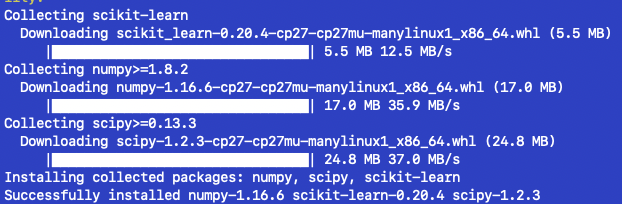

Standard stuff:

In [154]:
df[df["size"] < 1]

,library,dependencies,size,size_full,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,Forks,...,real avg,real std,real max,count,sys avg,sys std,sys max,user avg,user std,user max
16,packaging,['pyparsing'],0.264,11M /home/ubuntu/ve/randomenv/lib/python2.7/si...,66.0,1.0,1520.0,14600.0,"Sep 5, 2014",157.0,...,1.24725,0.06578943684209489,1.307,4.0,0.119,0.012987173159185446,0.131,1.08075,0.06337915009422795,1.1420000000000001
29,traitlets,"['enum34', 'decorator', 'ipython-genutils', 's...",0.828,11M /home/ubuntu/ve/randomenv/lib/python2.7/si...,97.0,2.0,347.0,14000.0,"Dec 7, 2013",163.0,...,1.40175,0.04627004070310144,1.455,4.0,0.15975,0.026348624252510795,0.196,1.14775,0.027801378862687087,1.177
34,markupsafe,[],0.108,11M /home/ubuntu/ve/randomenv/lib/python2.7/si...,34.0,0.0,746.0,73300.0,"Jun 22, 2010",105.0,...,0.9700000000000001,0.06784541251993383,1.021,3.0,0.11966666666666666,0.01285820101465728,0.129,0.8176666666666667,0.07508217720160582,0.863
35,markupsafe,[],0.108,11M /home/ubuntu/ve/randomenv/lib/python2.7/si...,34.0,0.0,746.0,73300.0,"Jun 22, 2010",105.0,...,0.94775,0.05084207575096308,0.9890000000000001,4.0,0.12200000000000001,0.02485960578931212,0.142,0.7935,0.0452658811910251,0.8220000000000001
37,jupyter-core,['traitlets'],0.828,11M /home/ubuntu/ve/randomenv/lib/python2.7/si...,NaN,2.0,143.0,1980.0,"Jul 2, 2015",NaN,...,1.53825,0.14427144554623417,1.67,4.0,0.178,0.017511900715418267,0.192,1.24925,0.13484898961430905,1.369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,overpy,[],0.148,11M /home/ubuntu/ve/randomenv/lib/python2.7/si...,11.0,0.0,3.0,61.0,"Dec 14, 2014",49.0,...,2.081,NaN,2.081,1.0,0.32799999999999996,NaN,0.32799999999999996,1.641,NaN,1.641
1989,fastjsonschema,[],0.168,11M /home/ubuntu/ve/randomenv/lib/python2.7/si...,17.0,0.0,38.0,15.0,"Oct 5, 2016",46.0,...,1.334,NaN,1.334,1.0,0.2,NaN,0.2,1.063,NaN,1.063
1990,geoplotlib,[],0.220,11M /home/ubuntu/ve/randomenv/lib/python2.7/si...,2.0,0.0,0.0,11.0,"May 21, 2015",155.0,...,1.3159999999999998,NaN,1.3159999999999998,1.0,0.19899999999999998,NaN,0.19899999999999998,1.031,NaN,1.031
1991,ppft,[],0.272,11M /home/ubuntu/ve/randomenv/lib/python2.7/si...,2.0,1.0,4.0,61.0,"Jan 14, 2015",10.0,...,0.843,NaN,0.843,1.0,0.13,NaN,0.13,0.679,NaN,0.679


<AxesSubplot:xlabel='size', ylabel='Count'>

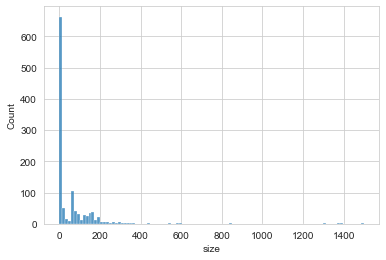

In [157]:
sns.histplot(df["size"])

(0.0, 200.0)

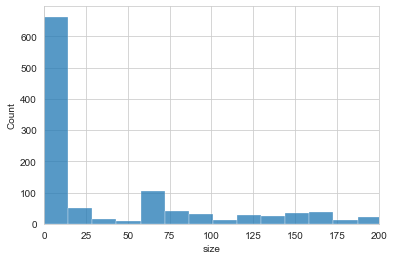

In [160]:
fig, ax = plt.subplots()
sns.histplot(df["size"], ax=ax)
ax.set_xlim(0,200)

<a name='e3'></a>
## 7. Scrape csv EDA

 - Package stats
 - Package versions
 
 Columns: ['library', 'Contributors', 'Dependencies', 'Dependent packages', 'Dependent repositories', 'First release', 'Forks', 'Latest release', 'Open Issues/PRs', 'Repository size', 'SourceRank', 'Stars', 'Total releases', 'Version Number', 'Version Time', 'Watchers']
<br>

Version related stuff:

In [264]:
df["Version Time"][0]

'[datetime.datetime(2021, 5, 8, 5, 47, tzinfo=<UTC>), datetime.datetime(2021, 3, 31, 8, 18, tzinfo=<UTC>), datetime.datetime(2021, 3, 26, 7, 50, tzinfo=<UTC>), datetime.datetime(2021, 3, 11, 5, 40, tzinfo=<UTC>), datetime.datetime(2021, 3, 11, 2, 56, tzinfo=<UTC>), datetime.datetime(2021, 2, 19, 6, 41, tzinfo=<UTC>), datetime.datetime(2021, 1, 28, 8, 34, tzinfo=<UTC>), datetime.datetime(2020, 11, 12, 4, 43, tzinfo=<UTC>), datetime.datetime(2020, 9, 15, 7, 11, tzinfo=<UTC>), datetime.datetime(2020, 8, 24, 22, 26, tzinfo=<UTC>), datetime.datetime(2020, 7, 17, 20, 21, tzinfo=<UTC>), datetime.datetime(2020, 6, 18, 22, 11, tzinfo=<UTC>), datetime.datetime(2020, 6, 17, 19, 42, tzinfo=<UTC>), datetime.datetime(2020, 3, 18, 22, 6, tzinfo=<UTC>), datetime.datetime(2020, 3, 4, 23, 27, tzinfo=<UTC>), datetime.datetime(2020, 2, 3, 6, 5, tzinfo=<UTC>), datetime.datetime(2020, 2, 3, 6, 2, tzinfo=<UTC>), datetime.datetime(2019, 11, 21, 22, 51, tzinfo=<UTC>), datetime.datetime(2019, 10, 25, 3, 56, tzi

<a name='c1'></a>
## 8. Correlational plots for time vs size

<br>

<AxesSubplot:xlabel='size', ylabel='real avg'>

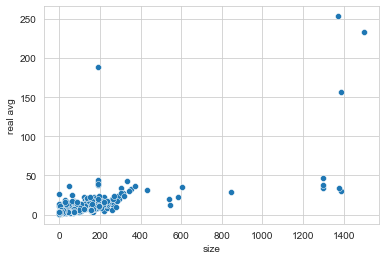

In [185]:
sns.scatterplot(x="size", y="real avg", data=df)

<a name='c2'></a>
## 9. Correlational plots w/ stats

Not much to show for now, nothing really shows anything impressive

<br>

<AxesSubplot:xlabel='Dependencies', ylabel='real avg'>

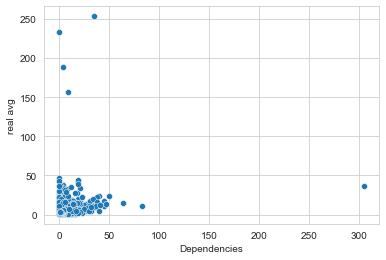

In [188]:
sns.scatterplot(x="Dependencies", y="real avg", data=df)

<a name='tree'></a>
## 10. Dependencies tree

<br>

In [352]:
df

,library,dependencies,size,size_full,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,Forks,...,real avg,real std,real max,count,sys avg,sys std,sys max,user avg,user std,user max
0,matplotlib,"[python-dateutil, kiwisolver, numpy, six, cycl...",98.800,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...,763.0,0.0,10100.0,39600.0,"Jan 9, 2006",5858.0,...,5.8863,0.218406,6.394,10.0,0.5602,0.044919,0.661,5.1363,0.142811,5.447
1,numpy,[],70.000,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...,736.0,0.0,25100.0,84900.0,"Dec 2, 2006",5611.0,...,3.029,NaN,3.029,1.0,0.316,NaN,0.316,2.652,NaN,2.652
2,numpy,[],70.000,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...,736.0,0.0,25100.0,84900.0,"Dec 2, 2006",5611.0,...,3.1207,0.039472,3.194,10.0,0.3194,0.043095,0.387,2.7519,0.053297,2.827
3,pandas,"[numpy, python-dateutil, pytz]",120.800,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...,970.0,6.0,14400.0,38400.0,"Dec 25, 2009",12543.0,...,6.885,NaN,6.885,1.0,0.611,NaN,0.611,6.181,NaN,6.181
4,pandas,"[numpy, python-dateutil, pytz]",120.800,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...,970.0,6.0,14400.0,38400.0,"Dec 25, 2009",12543.0,...,6.543222,0.181254,6.87,9.0,0.629556,0.063287,0.736,5.820889,0.140243,6.043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,requests_toolbelt,[requests],4.096,11M /home/ubuntu/ve/randomenv/lib/python2.7/si...,NaN,1.0,659.0,4090.0,"Jan 18, 2014",NaN,...,1.947,NaN,1.947,1.0,0.161,NaN,0.161,1.678,NaN,1.678
2004,neovim,[pynvim],2.088,11M /home/ubuntu/ve/randomenv/lib/python2.7/si...,45.0,1.0,8.0,255.0,"May 9, 2014",96.0,...,3.857,NaN,3.857,1.0,0.623,NaN,0.623,3.148,NaN,3.148
2005,praat-parselmouth,[numpy],70.000,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...,3.0,1.0,4.0,7.0,"Jun 11, 2017",59.0,...,4.154,NaN,4.154,1.0,0.45,NaN,0.45,3.288,NaN,3.288
2009,cma,[numpy],71.600,70M /home/ubuntu/ve/randomenv/lib/python2.7/si...,6.0,2.0,36.0,42.0,"May 12, 2014",102.0,...,3.356,NaN,3.356,1.0,0.358,NaN,0.358,2.905,NaN,2.905


In [347]:
edge_list = pd.DataFrame(columns= ['Library', 'Dependency', 'Weight'])

counter = 0
a = datetime.now()
for index, row in df.iterrows():
    source = row["library"]
    for d in row["dependencies"]:
        edge_list = edge_list.append({'Library': source, 'Dependency': d, 'Weight': 1}, ignore_index=True)
    counter += 1
    if counter % 100 == 0:
        b = datetime.now()
        print(str(counter) + ": " + str((b - a).seconds))
        a = datetime.now()
            
edge_list

100: 0
200: 0
300: 0
400: 0
500: 0
600: 0
700: 0
800: 0
900: 0
1000: 0
1100: 0


,Library,Dependency,Weight
0,matplotlib,python-dateutil,1
1,matplotlib,kiwisolver,1
2,matplotlib,numpy,1
3,matplotlib,six,1
4,matplotlib,cycler,1
...,...,...,...
2858,requests_toolbelt,requests,1
2859,neovim,pynvim,1
2860,praat-parselmouth,numpy,1
2861,cma,numpy,1


In [353]:
D = nx.convert_matrix.from_pandas_edgelist(edge_list,'Library','Dependency',['Weight'],nx.DiGraph)

In [354]:
nx.info(D)

'Name: \nType: DiGraph\nNumber of nodes: 1208\nNumber of edges: 2787\nAverage in degree:   2.3071\nAverage out degree:   2.3071'

In [371]:
[n for n in D.neighbors("dask")]

[]

In [379]:
degree_centrality = nx.degree_centrality(D)

sort_orders = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

for i in sort_orders:
	print(i[0], i[1])

numpy 0.17978458989229493
six 0.17315658657829328
requests 0.12013256006628002
scipy 0.06876553438276718
pandas 0.0579950289975145
matplotlib 0.05385252692626346
notebook 0.035625517812758904
future 0.035625517812758904
setuptools 0.03396851698425849
ipython 0.02816901408450704
enum34 0.02816901408450704
pytest 0.027340513670256833
ipywidgets 0.026512013256006627
traitlets 0.026512013256006627
tornado 0.026512013256006627
python-dateutil 0.02568351284175642
click 0.024855012427506214
tqdm 0.02236951118475559
pytz 0.019884009942004968
nbconvert 0.019884009942004968
futures 0.019884009942004968
tensorflow 0.019884009942004968
sphinx 0.019884009942004968
jsonschema 0.019055509527754762
pyyaml 0.019055509527754762
lxml 0.019055509527754762
mlflow 0.019055509527754762
jinja2 0.018227009113504555
protobuf 0.01739850869925435
google-auth 0.01739850869925435
tensorflow-gpu 0.01739850869925435
streamlit 0.01739850869925435
tensorflow-cpu 0.01739850869925435
scikit-learn 0.016570008285004142
typ

<a name='Heatmap'></a>
## 11. Heatmap

<br>

<AxesSubplot:>

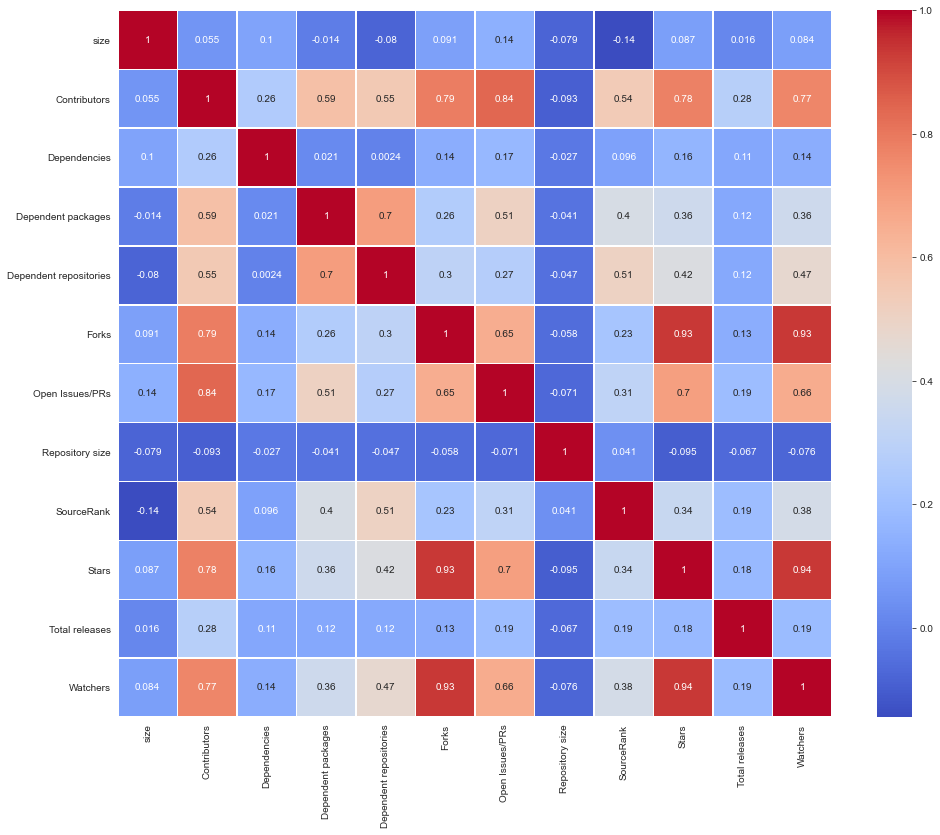

In [291]:
plt.figure(figsize=(16,13))
heatmap_df = df
cor = heatmap_df.corr()
sns.heatmap(cor, annot=True, cmap="coolwarm", linewidths=.5)